In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
import joblib
import os

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping



In [13]:
df_soh = pd.read_csv('filtered_df_with_soh.csv')
df_soh.head()

,Voltage_measured,Temperature_measured,id_cycle,ambient_temperature,Time,battery_name,Capacity,SoH
0,4.181907,26.429257,3,24,0.000,B0028,1.804685,99.99454
1,4.181887,26.432189,3,24,9.360,B0028,1.804685,99.99454
2,3.942821,26.448103,3,24,19.547,B0028,1.804685,99.99454
3,4.166704,26.507287,3,24,29.500,B0028,1.804685,99.99454
4,3.930981,26.555082,3,24,39.469,B0028,1.804685,99.99454


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                10400     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
120/120 [==============================] - 2s 5ms/step - loss: 0.2752 - val_loss: 0.2031
Epoch 2/200
120/120 [==============================] - 0s 2ms/step - loss: 0.0587 - val_loss: 0.1365
Epoch 3/200
120/120 [==============================] - 0s 2ms/step - loss: 0.044

C:\Users\sarak\anaconda3\envs\portf01\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 18ms/step


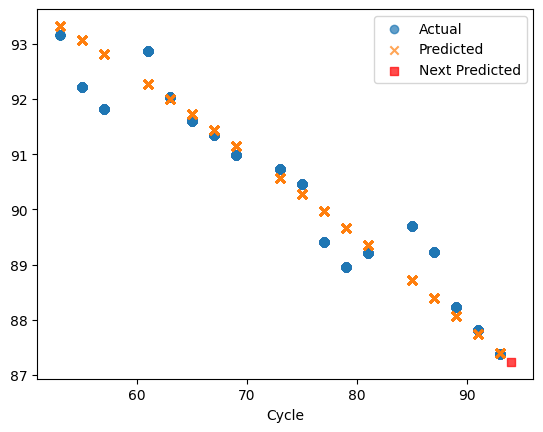

In [14]:
from sklearn.preprocessing import MinMaxScaler

# Assuming df_selected is your original data
battery_name = 'B0029'
df_selected = df_soh[df_soh['battery_name'] == 'B0029']

# Extract features and target
X_lstm = df_selected['id_cycle'].values.reshape(-1, 1)
y_lstm = df_selected['SoH'].values.reshape(-1, 1)

# Initialize the Scaler
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# Scale the data
X_lstm = X_scaler.fit_transform(X_lstm)
y_lstm = y_scaler.fit_transform(y_lstm)

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.40, shuffle=False)

# Create a Sequential model
model = Sequential()

# Add an LSTM layer with input shape (timesteps, features)
model.add(LSTM(50, input_shape=(X_train.shape[1], 1)))

# Add a Dropout layer to prevent overfitting
model.add(Dropout(0.2))

# Add a Dense layer with one output node (for regression)
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Display the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Save the model
model.save('lstm_model_scaled_data.h5')

# Predict on the test set
y_predict = model.predict(X_test)

# Reverse scaling for plotting
X_test = X_scaler.inverse_transform(X_test)
y_test = y_scaler.inverse_transform(y_test)
y_predict = y_scaler.inverse_transform(y_predict)

# Plot the results
plt.scatter(X_test, y_test, label='Actual', marker='o', alpha=0.7)
plt.scatter(X_test, y_predict, label='Predicted', marker='x', alpha=0.7)

# Adding the single point with a different color
max_cycle = df_selected[df_selected['battery_name'] == battery_name]['id_cycle'].max()
next_cycle = max_cycle + 1
next_cycle_scaled = X_scaler.transform(np.array([[next_cycle]]))
next_cycle_prediction_scaled = model.predict(next_cycle_scaled)
next_cycle_prediction = y_scaler.inverse_transform(next_cycle_prediction_scaled)

plt.scatter(next_cycle, next_cycle_prediction, label='Next Predicted', marker='s', color='red', alpha=0.7)

plt.xlabel('Cycle')
plt.legend()
plt.show()


1/1 [==============================] - 0s 19ms/step


<function matplotlib.pyplot.xlabel(xlabel: 'str', fontdict: 'dict[str, Any] | None' = None, labelpad: 'float | None' = None, *, loc: "Literal['left', 'center', 'right'] | None" = None, **kwargs) -> 'Text'>

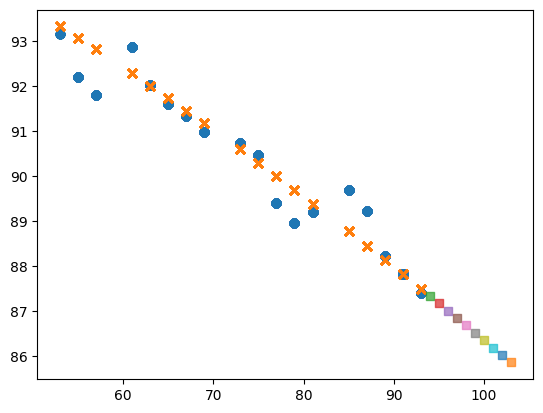

In [10]:
# Get the last known cycle
last_cycle = df_selected[df_selected['battery_name'] == battery_name]['id_cycle'].max()

# Predict for the next 10 cycles
next_cycles = np.array([[i] for i in range(last_cycle+1, last_cycle+11)])
next_cycles_scaled = X_scaler.transform(next_cycles)

# Make predictions for the next 10 cycles
next_cycle_predictions_scaled = model.predict(next_cycles_scaled)
next_cycle_predictions = y_scaler.inverse_transform(next_cycle_predictions_scaled)

# Plot the results
plt.scatter(X_test, y_test, label='Actual', marker='o', alpha=0.7)
plt.scatter(X_test, y_predict, label='Predicted', marker='x', alpha=0.7)

# Add the next 10 cycle predictions to the plot
for i in range(10):
    plt.scatter(next_cycles[i], next_cycle_predictions[i], label=f'Next Predicted {i+1}', marker='s', alpha=0.7)

plt.xlabel

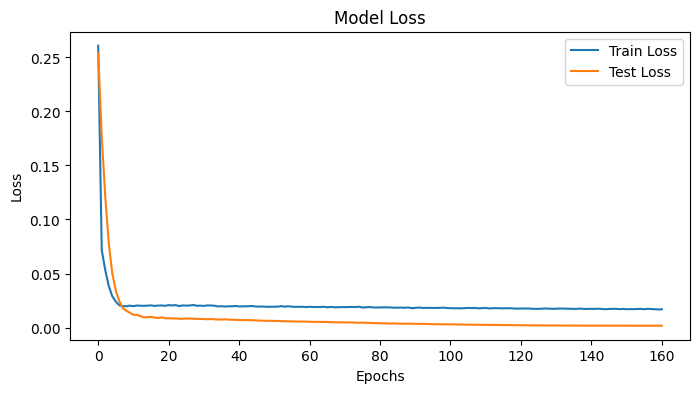

In [11]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()

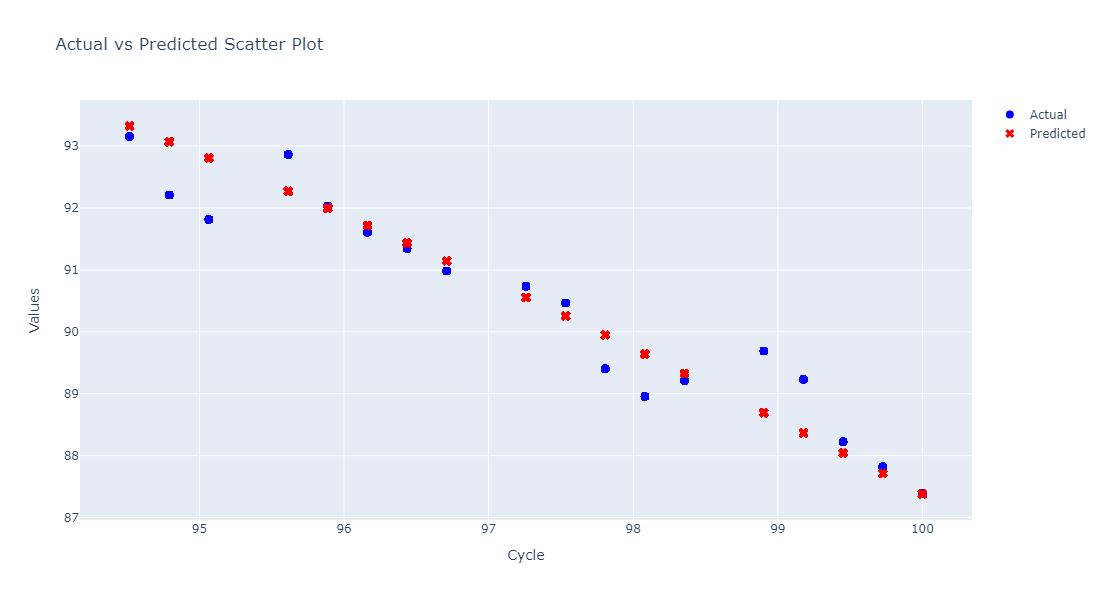

In [145]:
import plotly.graph_objects as go


# Create a scatter plot
fig = go.Figure()

# Actual values
fig.add_trace(go.Scatter(
    x=X_test_original.flatten(),
    y=y_test_original.flatten(),
    mode='markers',
    marker=dict(color='blue', size=8, symbol='circle'),
    name='Actual'
))

# Predicted values
fig.add_trace(go.Scatter(
    x=X_test_original.flatten(),
    y=y_predict_original.flatten(),
    mode='markers',
    marker=dict(color='red', size=8, symbol='x'),
    name='Predicted'
))

# Customize layout
fig.update_layout(
    title='Actual vs Predicted Scatter Plot',
    xaxis_title='Cycle',
    yaxis_title='Values',
    showlegend=True,
    width=800,
    height=600
)

# Show the plot
fig.show()
